In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet
import gc
import cPickle as pickle

In [3]:
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))

In [4]:
dim=(54, 4100, 1704)

In [20]:
def get_series(name):
    a=np.load("../input/s4/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==dim
    return b
def get_series2(name):
    a=np.load("../input/s4/"+name+".npz")
    #print a.files
    b=a['arr_0']
    assert b.shape==(4100, 54, 1704)
    return b
def save_series(arr,name):
    assert arr.shape==dim
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s4/"+name, arr)
def save_series2(arr,name):
    print arr.dtype, arr.nbytes/1024.0**2
    np.savez_compressed("../input/s4/"+name, arr)    
def s_lag(arr,lag=1):
    l,m,n=arr.shape
    assert lag>0 and lag<n
    a=arr[:,:,:-lag]
    b=np.empty(shape=[l,m,lag],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([b,a],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

def forward(arr,step=1):
    l,m,n=arr.shape
    assert step>0 and step<n
    a=arr[:,:,step:]
    b=np.empty(shape=[l,m,step],dtype=arr.dtype)
    b.fill(np.nan)
    ba=np.concatenate([a,b],axis=2)
    assert ba.shape==arr.shape
    assert ba.dtype==arr.dtype
    return ba

In [6]:
def moving_average_axis3(a, n=3,nan_periods=None):
    a=a.copy()
    assert len(a.shape)==3
    if nan_periods is None: nan_periods=n/2
    nanidx=np.isnan(a)
    a[nanidx]=0
    l,m,_=a.shape
    cusum_a = np.concatenate([np.zeros(shape=[l,m,n]),np.cumsum(a, axis=2,dtype=float)],axis=2)
    cusum_a_cnt=np.concatenate([np.zeros(shape=[l,m,n]),np.cumsum(~nanidx,axis=2, dtype=float)],axis=2)
    b=cusum_a[:,:,(n-0):]-cusum_a[:,:,:-(n-0)]
    c=cusum_a_cnt[:,:,n-0:]-cusum_a_cnt[:,:,:-(n-0)]
    c[c<=nan_periods]=np.nan
    ret=(b/c)
    #pad=np.empty(shape=[l,m,n-1],dtype=ret.dtype)
    #pad.fill(np.nan)
    #ret=np.concatenate([pad,ret],axis=2)
    assert ret.shape==a.shape, ret.shape
    return ret

In [7]:
def nan_equal(a,b):
    ret=( (np.abs(a - b)<1e1) | (numpy.isnan(a) & numpy.isnan(b)))
    #print np.where(~ret)
    #print a[~ret]
    #print b[~ret]
    return ret.all()
def test_mv():
    for i in range(30):
        print i,
        a=y0[i]
        df=pd.DataFrame(a.T,dtype=np.float64)
        b=pd.rolling_mean(df,window=3,min_periods=3/2+1).values
        c=y_mv3[i].T
        #print df.shape,b.shape,c.shape
        #print np.nansum(np.abs(b-c))
        assert nan_equal(b,c)        

In [8]:
def season_ma_axis3(arr,season=3,window=5,nan_periods=None):
    assert len(arr.shape)==3
    arr=arr.copy()
    if nan_periods is None: nan_periods=window/2
    arr_sum=arr.astype(np.float64,copy=True)
    arr_sum[np.isnan(arr_sum)]=0
    arr_nan=(~np.isnan(arr)).astype(np.float)
    for i in range(1,window):
        laged=lag(arr,lag=season*window)
        laged[np.isnan(laged)]=0
        #print laged
        arr_sum+=laged
        arr_nan+=~np.isnan(laged)
    #print arr_sum
    #print arr_nan
    arr_nan[arr_nan<=nan_periods]=np.nan  
    ret=arr_sum/arr_nan
    assert ret.shape==arr.shape
    return ret

In [9]:
y0=get_series("y_0")

In [13]:
y0.shape

(54, 4100, 1704)

# trend

In [84]:
a=np.nanmean(np.reshape(y0,(-1,1704)),axis=0,dtype=np.float)

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


(array([ 365,  730, 1095, 1461, 1688, 1689, 1690, 1691, 1692, 1693, 1694,
        1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703]),)

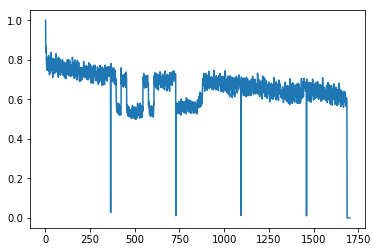

In [85]:
plt.plot(a)
np.where(a<0.1)

In [89]:
from pandas.plotting import autocorrelation_plot

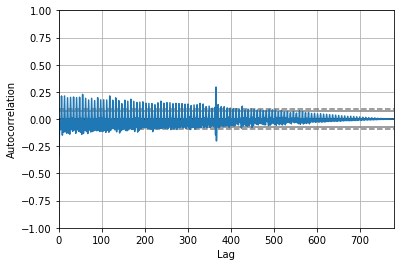

In [98]:
autocorrelation_plot(diff(pd.Series(a[900:1680]).fillna(method='ffill')) )

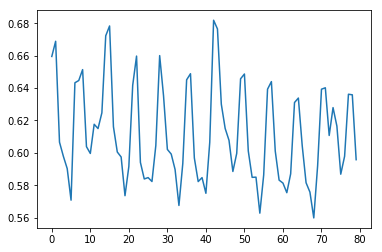

In [99]:
plt.plot(a[1600:1680])


In [46]:
np.nanmean(y0,dtype=float)

0.6336851243655568

In [22]:
from sklearn.metrics import confusion_matrix

In [38]:
def confusion(a,b):
    ind=(~np.isnan(a)) &(~np.isnan(b))
    a=a[ind][-100*1000:]
    b=b[ind][-100*1000:]
    # print a.shape,b.shape
    aa=np.mean((a==0)*(b==0),dtype=np.float)
    ab=np.mean((a==0)*(b==1),dtype=np.float)
    ba=np.mean((a==1)*(b==0),dtype=np.float)
    bb=np.mean((a==1)*(b==1),dtype=np.float)
    return np.array([[aa,ab],[ba,bb]])

In [39]:
a=s_lag(y0,1)

In [40]:
confusion(y0,a)

array([[ 0.34625,  0.11449],
       [ 0.11181,  0.42745]])

In [41]:
a=s_lag(y0,2)
confusion(y0,a)

array([[ 0.33319,  0.12744],
       [ 0.12305,  0.41632]])

In [42]:
a=s_lag(y0,6)
confusion(y0,a)

array([[ 0.31667,  0.1392 ],
       [ 0.12814,  0.41599]])

In [43]:
a=s_lag(y0,7)
confusion(y0,a)

array([[ 0.3134 ,  0.14005],
       [ 0.12912,  0.41743]])

In [44]:
a=s_lag(y0,8)
confusion(y0,a)

array([[ 0.30866,  0.1459 ],
       [ 0.1313 ,  0.41414]])

In [45]:
a=s_lag(y0,1)*s_lag(y0,2)
confusion(y0,a)

array([[ 0.38751,  0.07403],
       [ 0.18543,  0.35303]])

In [47]:
a=s_lag(y0,1)*s_lag(y0,2)*s_lag(y0,3)
confusion(y0,a)

array([[ 0.40499,  0.05339],
       [ 0.23772,  0.3039 ]])

In [100]:
a=s_lag(1-y0,1)*s_lag(1-y0,2)*s_lag(1-y0,3)
confusion(y0,a)

array([[ 0.19858,  0.2598 ],
       [ 0.51304,  0.02858]])

In [63]:
a=s_lag(y0,1)*s_lag(y0,2)*s_lag(y0,3)*s_lag(y0,4)
confusion(y0,a)

array([[ 0.41869,  0.04035],
       [ 0.27756,  0.2634 ]])

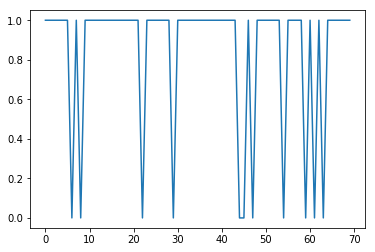

In [56]:
plt.plot(y0[0,89,1600:1670])

In [68]:
b=moving_average_axis3(s_lag(y0),3)

In [69]:
a=b

In [70]:
confusion(y0,(a==0)*1.0)

array([[ 0.20237,  0.26021],
       [ 0.50938,  0.02804]])

In [71]:
confusion(y0,a==3)

array([[ 0.46258,  0.     ],
       [ 0.53742,  0.     ]])

In [60]:
np.nanmean(b,dtype=np.float)

0.63447095842243317

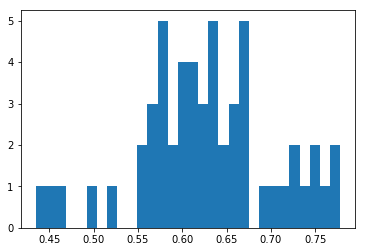

In [78]:
lst=[]
for i in range(y0.shape[0]):
    lst.append(np.nanmean(y0[i],dtype=float))
plt.hist(lst,bins=30);

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


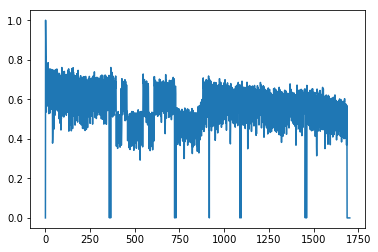

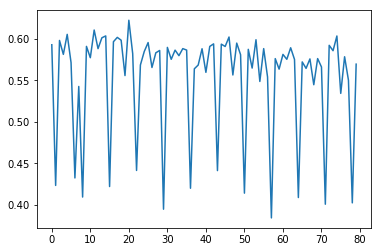

In [110]:
lst=[]
for i in range(y0.shape[2]):
    lst.append(np.nanmean(y0[0,:,i],dtype=float))
lst=np.array(lst)
lst[np.isnan(lst)]=0    
plt.plot(lst);plt.show()
plt.plot(lst[1600:1680])

In [82]:
lst=[]
for i in range(y0.shape[1]):
    if i%100==0:print i,
    lst.append(np.nanmean(y0[:,i],dtype=float))
lst=np.array(lst)
lst[np.isnan(lst)]=0
plt.hist(lst,bins=30);

0 100 200 300 400 500 600 700 800 900

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000


0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


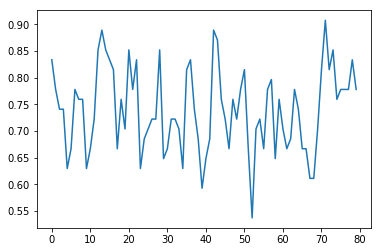

In [109]:
lst=[]
for i in range(y0.shape[2]):
    if i%100==0:print i,
    lst.append(np.nanmean(y0[:,1123,i],dtype=float))
lst=np.array(lst)
lst[np.isnan(lst)]=0
plt.plot(lst);plt.show()
plt.plot(lst[1600:1680])